In [1]:
using Turing, Plots, Random
using ReverseDiff, Memoization
Turing.setadbackend(:reversediff);
Turing.setrdcache(true);

In [2]:
Random.seed!(0);
#Generate data
T = 120

w1, w2, w3 = 0.1, 0.25, 1

x_data = [randn()]
y_data = [x_data[end]+0.1*randn()]
for t=2:25
    append!(x_data, x_data[end] + sqrt(1/w1)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=26:75
    append!(x_data, x_data[end] + sqrt(1/w2)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=76:T
    append!(x_data, x_data[end] + sqrt(1/w3)*randn())
    append!(y_data, x_data[end] + randn())
end

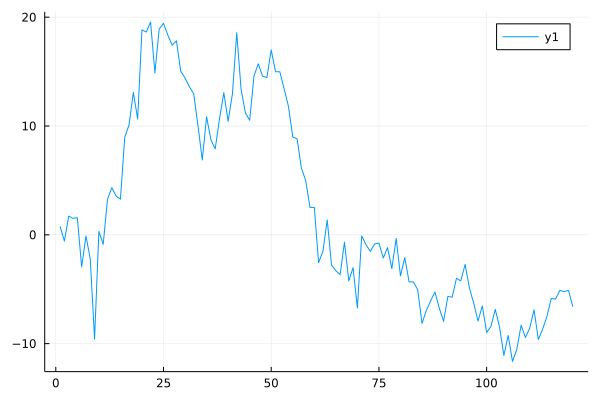

In [3]:
plot(y_data)

In [4]:
@model function SSSM(y)
    vars = [10, 4, 1]
    T = length(y)
    z = tzeros(Int,T-1)
    x = Vector(undef, T)
    #M = Vector{Vector}(undef,3) # Transition matrix
    M_1 ~ Dirichlet([100,1,1])
    M_2 ~ Dirichlet([1,100,1])
    M_3 ~ Dirichlet([1,1,100])
    M = [M_1, M_2, M_3] # Transition matrix
    
    z[1] ~ Categorical(3)
    x[1] ~ Normal()
    y[1] ~ Normal(x[1],sqrt(1))
    for t = 2:T-1
        x[t] ~ Normal(x[t-1],sqrt(vars[z[t-1]]))
        y[t] ~ Normal(x[t],sqrt(1))
        z[t] ~ Categorical(vec(M[z[t-1]]))
    end
    x[T] ~ Normal(x[T-1],sqrt(vars[z[T-1]]))
    y[T] ~ Normal(x[T],sqrt(1))
end

SSSM (generic function with 2 methods)

In [5]:
gibbs = Gibbs(HMC(0.2,20,:x,:M_1,:M_2,:M_3),PG(50,:z))
chain = sample(SSSM(y_data),gibbs,1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:25:59


Chains MCMC chain (1000×249×1 Array{Float64,3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1580.49 seconds
Compute duration  = 1580.49 seconds
parameters        = M_1[1], M_1[2], M_1[3], M_2[1], M_2[2], M_2[3], M_3[1], M_3[2], M_3[3], z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], z[24], z[25], z[26], z[27], z[28], z[29], z[30], z[31], z[32], z[33], z[34], z[35], z[36], z[37], z[38], z[39], z[40], z[41], z[42], z[43], z[44], z[45], z[46], z[47], z[48], z[49], z[50], z[51], z[52], z[53], z[54], z[55], z[56], z[57], z[58], z[59], z[60], z[61], z[62], z[63], z[64], z[65], z[66], z[67], z[68], z[69], z[70], z[71], z[72], z[73], z[74], z[75], z[76], z[77], z[78], z[79], z[80], z[81], z[82], z[83], z[84], z[85], z[86], z[87], z[88], z[89], z[90], z[91], z[92], z[93], z[94], z[95], z[96], z[97], z[98], z[99], z[100], z[101], z[102], z[

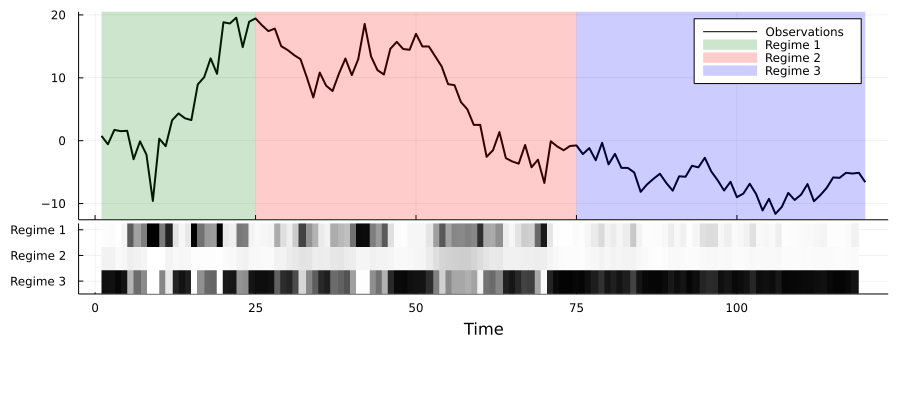

In [16]:
m_z = zeros(3,T-1)
for t=1:T-1
    dd = [(i, count(==(i), group(chain,:z).value.data[:,t])) for i in [1.0,2.0,3.0]]
    num1, num2, num3 = dd[1][2], dd[2][2], dd[3][2]
    num = num1+num2+num3
    m_z[1,t] = num1/num
    m_z[2,t] = num2/num
    m_z[3,t] = num3/num
end

estimate = zeros(12,T-1)
for i=1:4
    estimate[i,:] = 1. .- m_z[1,:]
    estimate[i+4,:] = 1. .- m_z[2,:]
    estimate[i+8,:] = 1. .- m_z[3,:]
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:T, y_data, w=2, labels = "Observations", legend=(:best), color=:black)
vspan!(p1,[1,25], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[25,75], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[75,T], color = :blue, alpha = 0.2, labels = "Regime 3");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-25.0mm)
yticks!([2:4:10;], ["Regime 1", "Regime 2", "Regime 3"])

p = plot(p1, p2, layout = l, size = (900, 400))

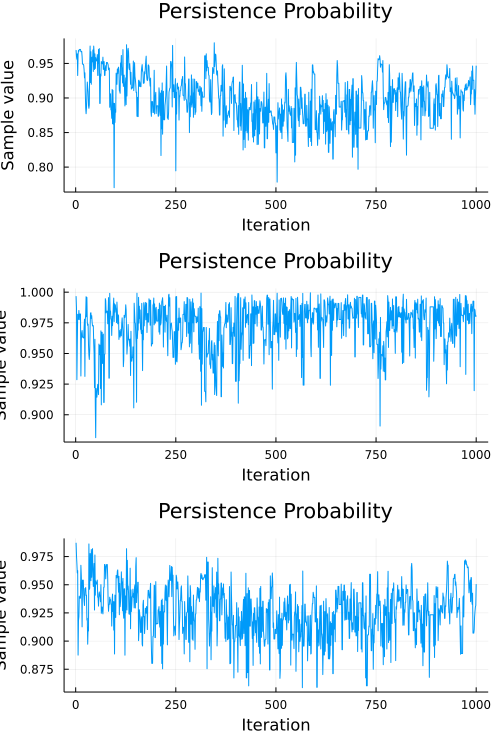

In [17]:
# Index the chain with the persistence probabilities.
subchain = chain[["M_1[1]", "M_2[2]", "M_3[3]"]]

plot(subchain,
     seriestype = :traceplot,
     title = "Persistence Probability",
     legend=false)

In [18]:
heideldiag(MCMCChains.group(chain, :M_1))[1]

Heidelberger and Welch diagnostic - Chain 1
  parameters     burnin   stationarity    pvalue      mean   halfwidth     tes ⋯
      Symbol      Int64           Bool   Float64   Float64     Float64     Boo ⋯

      M_1[1]   200.0000         1.0000    0.1428    0.8932      0.0089   1.000 ⋯
      M_1[2]   100.0000         1.0000    0.7301    0.0086      0.0007   1.000 ⋯
      M_1[3]   200.0000         1.0000    0.1446    0.0981      0.0096   1.000 ⋯
                                                                1 column omitted


In [19]:
heideldiag(MCMCChains.group(chain, :M_2))[1]

Heidelberger and Welch diagnostic - Chain 1
  parameters     burnin   stationarity    pvalue      mean   halfwidth     tes ⋯
      Symbol      Int64           Bool   Float64   Float64     Float64     Boo ⋯

      M_2[1]   400.0000         1.0000    0.4599    0.0102      0.0012   0.000 ⋯
      M_2[2]   100.0000         1.0000    0.0583    0.9736      0.0037   1.000 ⋯
      M_2[3]     0.0000         1.0000    0.1633    0.0158      0.0031   0.000 ⋯
                                                                1 column omitted


In [20]:
heideldiag(MCMCChains.group(chain, :M_3))[1]

Heidelberger and Welch diagnostic - Chain 1
  parameters     burnin   stationarity    pvalue      mean   halfwidth     tes ⋯
      Symbol      Int64           Bool   Float64   Float64     Float64     Boo ⋯

      M_3[1]   100.0000         1.0000    0.1950    0.0660      0.0062   1.000 ⋯
      M_3[2]   100.0000         1.0000    0.1426    0.0092      0.0019   0.000 ⋯
      M_3[3]   100.0000         1.0000    0.1765    0.9247      0.0051   1.000 ⋯
                                                                1 column omitted


In [21]:
using DelimitedFiles, DataFrames
writedlm("HMCestimates.txt", estimate)